## Code to Chapter 5 of LangChain for Life Science and Healthcare book, by Dr. Ivan Reznikov

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1LHTs4mmDKG9DKfzNAM3xxxw9tL4kjfDU?usp=sharing)

## Overview

This notebook demonstrates how to build sophisticated personal assistants using LangChain's LangGraph framework. We'll explore:

1. **Basic Tool Creation**: Building simple mathematical tools
2. **Agent Executors**: Creating agents that can use tools
3. **Multi-Agent Systems**: Coordinating multiple specialized agents
4. **Scientific Research Assistants**: Building domain-specific assistants
5. **Advanced Workflows**: Creating complex multi-step processes

## 1. Environment Setup

First, let's install all required packages and set up our environment.

In [ ]:
!pip install -q -U langchain  \
langchainhub \
langchain-community \
langchain-core \
langchain-experimental \
langchain-openai \
langchain-text-splitters \
langcodes \
langgraph \
langsmith \
libclang \
openai pandas matplotlib docarray grandalf semanticscholar arxiv xmltodict wikipedia

In [ ]:
!sudo apt-get install graphviz graphviz-dev
!pip -q install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
!pip freeze | grep "lang\|openai\|chroma\|arxiv"

arxiv==2.2.0
google-ai-generativelanguage==0.6.15
google-cloud-language==2.17.2
langchain==0.3.26
langchain-community==0.3.27
langchain-core==0.3.69
langchain-experimental==0.3.4
langchain-openai==0.3.28
langchain-text-splitters==0.3.8
langchainhub==0.1.21
langcodes==3.5.0
langgraph==0.5.3
langgraph-checkpoint==2.1.1
langgraph-prebuilt==0.5.2
langgraph-sdk==0.1.73
langsmith==0.4.7
language_data==1.3.0
libclang==18.1.1
openai==1.97.0


In [ ]:
from google.colab import userdata
import os


# Set OpenAI API key from Google Colab's user environment or default
def set_api_keys(
    default_openai_key: str = "YOUR_API_KEY", default_tavily_key: str = "YOUR_API_KEY"
) -> None:
    """Set the OpenAI API key from Google Colab's user environment or use a default value."""

    os.environ["OPENAI_API_KEY"] = (
        userdata.get("LC4LS_OPENAI_API_KEY") or default_openai_key
    )


set_api_keys()
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "lc4ls-ch5-langgraph-agents"
os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")

In [ ]:
from pydantic import BaseModel, Field
from langchain_core.tools import BaseTool, StructuredTool, tool, Tool
from typing import Optional, Type

from langchain.callbacks.manager import (
    AsyncCallbackManagerForToolRun,
    CallbackManagerForToolRun,
)

## 2. Building Basic Tools

### Mathematical Tools

Tools are the building blocks of agents. Let's create basic mathematical tools that our agents can use.


In [ ]:
class NumericInput2(BaseModel):
    a: float = Field(description="first number")
    b: float = Field(description="second number")


@tool("sum_2_numbers", args_schema=NumericInput2)
def sum2(a, b):
    """Sum two numbers."""
    return a + b


@tool("substract_2_numbers", args_schema=NumericInput2)
def substract2(a, b):
    """Subtract two numbers."""
    return a - b


@tool("multiply_2_numbers", args_schema=NumericInput2)
def multiply2(a, b):
    """Multiply two numbers."""
    return a * b


@tool("divide_2_numbers", args_schema=NumericInput2)
def divide2(a, b):
    """Divide two numbers."""
    return a / b

## 3. Creating Your First Agent

### Calculator Agent

Let's create a calculator agent that can perform mathematical operations using our tools.

In [ ]:
from langchain import hub
from langchain.agents import (
    AgentExecutor,
    create_tool_calling_agent,
    load_tools,
    create_react_agent,
)
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

# llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
tools = [sum2, substract2, multiply2, divide2]
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a calculator. Use PEMDAS. Make sure to use the tools",
        ),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)

calculator_agent = create_tool_calling_agent(llm, tools, prompt)
calculator_agent_executor = AgentExecutor(
    agent=calculator_agent, tools=tools, verbose=True, handle_parsing_errors=True
)

### Testing the Calculator Agent

In [ ]:
calculator_agent_executor.invoke({"input": "3 / 3 + 3 * 3"})



> Entering new AgentExecutor chain...

Invoking: `divide_2_numbers` with `{'a': 3, 'b': 3}`


1.0
Invoking: `multiply_2_numbers` with `{'a': 3, 'b': 3}`


9.0
Invoking: `sum_2_numbers` with `{'a': 1.0, 'b': 9.0}`


10.0The result of the expression \(3 / 3 + 3 * 3\) is \(10.0\).

> Finished chain.


{'input': '3 / 3 + 3 * 3',
 'output': 'The result of the expression \\(3 / 3 + 3 * 3\\) is \\(10.0\\).'}

In [ ]:
calculator_agent_executor.invoke(
    {"input": "Take half of the previous answer and deduct 5"}
)



> Entering new AgentExecutor chain...
I need the previous answer to perform the calculation. Could you please provide it?

> Finished chain.


{'input': 'Take half of the previous answer and deduct 5',
 'output': 'I need the previous answer to perform the calculation. Could you please provide it?'}

**Expected Output:**
- The agent will break down complex calculations into steps
- It will use the appropriate tools for each operation
- It maintains context between conversations

## 4. Scientific Research Assistant

### SCOPUS Query Generator

Let's build a sophisticated tool for generating SCOPUS API queries.

In [ ]:
from langchain_core.prompts import PromptTemplate, MessagesPlaceholder
from langchain_community.tools.pubmed.tool import PubmedQueryRun
from langchain_community.tools.semanticscholar.tool import SemanticScholarQueryRun
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
import requests

llm = ChatOpenAI(model="gpt-4o", temperature=0)
API_KEY = "7f59af901d2d86f78a1fd60c1bf9426a"

generate_scopus_url_template = """
    Generate a SCOPUS API query URL based on the user's request.

    Instructions:
    - Use Boolean operators (AND, OR, AND NOT) to combine keywords.
    - Use `&` for dates, sorting and formatting options
    - URL-encode the query string.
    - Use field restriction codes to search specific fields.
    - Use proximity operators (pre/n, w/n) for proximity searches.
    - Use wildcards (? for single character, * for multiple characters) for flexible searches.
    - Follow order of precedence rules: OR > AND > AND NOT.
    - Enclose exact phrases in braces {{}}.
    - Use double quotation marks "" for approximate phrases.

    Sorting:
        If user askes for most cited papers - use `sort=-citedby-count`
        If most recent or latest papers - use `sort=-coverDate`

    If the number of output or count isn't mentioned, set as count=10

    If author is mentioned - use the following filtering (for Ivan Reznikov):
        AUTHOR-NAME(Reznikov, I)

    If affilation is mentioned - use the following filtering (for Google):
        AFFIL(Google)

    If a data range is mentioned - use the following rules:
        before 2000: date=0-2020
        2000-2003: date=2000-2003
        in 2025: date=2025
        after 2000: date=2000-3000
    Always use `&` for dates!

    Categorical keywords and their explanations:
    - DOCTYPE: Document Type (e.g.,
        "ar": "Article",
        "bk": "Book",
        "cp": "Conference Paper",
        "re": "Review",
        "ed": "Editorial",
        "le": "Letter",
        "no": "Note",
        "pr": "Press Release",
        "sh": "Short Survey")

    If Subjarea can be extracted - extract it and use SUBJAREA: subjarea(ENVI)
    Else use TITLE-ABS-KEY: TITLE-ABS-KEY(renewable%20energy)

    - SUBJAREA: Subject Area (
        "AGRI": "Agricultural and Biological Sciences",
        "ARTS": "Arts and Humanities",
        "BIOC": "Biochemistry, Genetics and Molecular Biology",
        "BUSI": "Business, Management and Accounting",
        "CENG": "Chemical Engineering",
        "CHEM": "Chemistry",
        "COMP": "Computer Science",
        "DECI": "Decision Sciences",
        "DENT": "Dentistry",
        "EART": "Earth and Planetary Sciences",
        "ECON": "Economics, Econometrics and Finance",
        "ENER": "Energy",
        "ENGI": "Engineering",
        "ENVI": "Environmental Science",
        "HEAL": "Health Professions",
        "IMMU": "Immunology and Microbiology",
        "MATE": "Materials Science",
        "MATH": "Mathematics",
        "MEDI": "Medicine",
        "NEUR": "Neuroscience",
        "NURS": "Nursing",
        "PHAR": "Pharmacology, Toxicology and Pharmaceutics",
        "PHYS": "Physics and Astronomy",
        "PSYC": "Psychology",
        "SOCI": "Social Sciences",
        "VETE": "Veterinary",
        "MULT": "Multidisciplinary"
    )
    - AFFILCOUNTRY: Affiliation Country (e.g., USA, China, Japan)
    - LANGUAGE: Language of the document (e.g., English, French, German)
    - OPENACCESS: Open Access status (1 = Open Access, 0 = Subscription-based)

    Examples:
    User request: "list 10 most cited papers on quantum computing"
    URL query: https://api.elsevier.com/content/search/scopus?query=TITLE-ABS-KEY(quantum%20computing)&sort=-citedby-count&count=10&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "find papers on climate change from 2020 to 2023 in Environmental Science"
    URL query: https://api.elsevier.com/content/search/scopus?query=TITLE-ABS-KEY(climate%20change)%20AND%20subjarea(ENVI)&date=2020-2023&sort=-coverDate&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "find 5 most recent papers on langchain in Computer Science"
    URL query: https://api.elsevier.com/content/search/scopus?query=TITLE-ABS-KEY(langchain)%20AND%20subjarea(COMP)&sort=-coverDate&count=5&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "find 20 most recent papers on gene editing by author Li Q."
    URL query: https://api.elsevier.com/content/search/scopus?query=AUTHOR-NAME(Li,Q)%20AND%20all(gene%20editing)&sort=-coverDate&count=20&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: {user_query}
    URL query:
"""

generate_scopus_url_template = generate_scopus_url_template.replace(
    "{{API_KEY}}", API_KEY
)
generate_scopus_url_prompt = PromptTemplate.from_template(generate_scopus_url_template)

chain = (
    {"user_query": RunnablePassthrough()}
    | generate_scopus_url_prompt
    | llm
    | StrOutputParser()
)

generate_scopus_query_tool = Tool(
    name="generate_scopus_url",
    func=chain.invoke,
    description="A tool to generate a scopus url to retrieve scientific data",
)

# Additional examples for scopus:
"""
    User request: "list recent papers by author John Doe in chemistry"
    URL query: https://api.elsevier.com/content/search/scopus?query=authname(John%20Doe)%20AND%20subjarea(CHEM)&sort=-coverDate&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "list papers on renewable energy published in 2021 with wind and solar in abstract"
    URL query: https://api.elsevier.com/content/search/scopus?query=TITLE-ABS-KEY(renewable%20energy)%20AND%20abs(wind%20solar)&date=2021&subj=ENER&sort=-coverDate&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "list papers on nanotechnology from stanford"
    URL query: https://api.elsevier.com/content/search/scopus?query=TITLE-ABS-KEY(nanotechnology)%20AND%20AFFIL(stanford)&sort=-coverDate&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "find papers regarding openai published in 2020"
    URL query: https://api.elsevier.com/content/search/scopus?query=TITLE-ABS-KEY(openai)&date=2020&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "find all papers by openai"
    URL query: https://api.elsevier.com/content/search/scopus?query=(openai)&sort=-coverDate&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "find recent papers that include aspirin and water"
    URL query: https://api.elsevier.com/content/search/scopus?query=CHEM(aspirin&20water)&sort=-coverDate&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "find 20 latest books on renewable energy"
    URL query: https://api.elsevier.com/content/search/scopus?query=TITLE-ABS-KEY(renewable%20energy)%20AND%20doctype(bk)&sort=-coverDate&count=20&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "return data regarding 10.1007/s00202-004-0261-3 article"
    URL query: https://api.elsevier.com/content/search/scopus?query=DOI(10.1007/s00202-004-0261-3)&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "return data regarding 9780123456789 isbn"
    URL query: https://api.elsevier.com/content/search/scopus?query=ISBN(9780123456789)&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "list articles with chatgpt keyword in french"
    URL query: https://api.elsevier.com/content/search/scopus?query=key(chatgpt)%20AND%20Language(french)&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "find 20 latest open access articles in large language models"
    URL query: https://api.elsevier.com/content/search/scopus?query=TITLE-ABS-KEY(large%20language%20models)%20AND%20openaccess(1)&sort=-coverDate&count=20&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "find papers that cite Attention Is All You Need"
    URL query: https://api.elsevier.com/content/search/scopus?query=ref(Attention%20Is%20All%20You%20Need)&sort=-coverDate&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "return data about GPT-4 Technical Report paper"
    URL query: https://api.elsevier.com/content/search/scopus?query=title(GPT-4%20Technical%20Report)&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "find articles in artificial intelligence in medicine before 2000"
    URL query: https://api.elsevier.com/content/search/scopus?query=TITLE-ABS-KEY(artificial%20intelligence)%20AND%20subjarea(MEDI)&date(0-2000)&sort=-coverDate&count=20&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson

    User request: "find papers on cancer research from China in Medicine"
    URL query: https://api.elsevier.com/content/search/scopus?query=TITLE-ABS-KEY(cancer%20research)%20AND%20AFFILCOUNTRY(China)&subj=MEDI&sort=-coverDate&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson
"""

'\n    User request: "list recent papers by author John Doe in chemistry"\n    URL query: https://api.elsevier.com/content/search/scopus?query=authname(John%20Doe)%20AND%20subjarea(CHEM)&sort=-coverDate&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson\n\n    User request: "list papers on renewable energy published in 2021 with wind and solar in abstract"\n    URL query: https://api.elsevier.com/content/search/scopus?query=TITLE-ABS-KEY(renewable%20energy)%20AND%20abs(wind%20solar)&date=2021&subj=ENER&sort=-coverDate&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson\n\n    User request: "list papers on nanotechnology from stanford"\n    URL query: https://api.elsevier.com/content/search/scopus?query=TITLE-ABS-KEY(nanotechnology)%20AND%20AFFIL(stanford)&sort=-coverDate&apiKey={{API_KEY}}&view=STANDARD&httpAccept=application%2Fjson\n\n    User request: "find papers regarding openai published in 2020"\n    URL query: https://api.elsevier.com/content/search/scopus

### URL Request Tool

In [ ]:
@tool("request_url")
def request_url(url):
    "Tool for querying url"
    headers = {
        "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
        "accept-language": "en-US,en;q=0.9,ru;q=0.8",
        "cache-control": "max-age=0",
        # 'cookie': 'AMCVS_4D6368F454EC41940A4C98A6%40AdobeOrg=1; __cf_bm=vyLwhM.5yYUJUs8.uPGsa8PDR4AuQguVM2id9mVp.ks-1716273084-1.0.1.1-dffFtQVqLTeuRYW_lSnIVfEzbgIUDOehw3nmnzJt0ZbsHND3.1fvKWtwMF3pzMwp.Y7BenR.ZdplnC7eSi4bTw; test=cookie; AMCV_4D6368F454EC41940A4C98A6%40AdobeOrg=-408604571%7CMCIDTS%7C19864%7CMCMID%7C32223060440167140023422064896007367729%7CMCAID%7CNONE%7CMCOPTOUT-1716280359s%7CNONE%7CvVersion%7C4.6.0',
        "priority": "u=0, i",
        #'referer': 'https://colab.research.google.com/',
        "sec-ch-ua": '"Chromium";v="124", "Google Chrome";v="124", "Not-A.Brand";v="99"',
        "sec-ch-ua-mobile": "?0",
        "sec-ch-ua-platform": '"Linux"',
        "sec-fetch-dest": "document",
        "sec-fetch-mode": "navigate",
        "sec-fetch-site": "cross-site",
        "sec-fetch-user": "?1",
        "upgrade-insecure-requests": "1",
        "user-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36",
    }

    response = requests.get(
        url,
        headers=headers,
    )

    if response.status_code == 200:
        return response.json()["search-results"]["entry"]
    else:
        print(response.status_code, response.text)
        return None

## 5. Multi-Source Scientific Agent

Let's create an agent that can search across multiple scientific databases.

In [ ]:
agent_prompt = hub.pull("hwchase17/react")

agent_prompt_instructions = """
You are a scientific search assistant. You have access to SCOPUS and arXiv.
Do not retrieve same tool multiple times!

Instructions:
- To query SCOPUS, first generate a query using generate_scopus_url and execute it using request_url tool
- If arXiv, PubMed, SemanticScholar or SCOPUS is specifically mentioned - query them.
- If a general question is asked - use all 4 tools: PubMed, SemanticScholar, arXiv and SCOPUS and aggregate the final results

Provide final result in the following format:
ArXiv results:
<arxiv results>

SCOPUS results:
<scopus results>
"""

prompt = agent_prompt.partial(instructions=agent_prompt_instructions)

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
tools = load_tools(["arxiv"]) + [
    generate_scopus_query_tool,
]

In [ ]:
sci_search_agent = create_react_agent(llm, tools, agent_prompt)
agent_executor = AgentExecutor(
    agent=sci_search_agent, tools=tools, verbose=True, handle_parsing_errors=True
)

In [ ]:
result = agent_executor.invoke(
    {
        "input": "List 5 papers dedicated to langchain published in the beginning of 2025",
    }
)



> Entering new AgentExecutor chain...
I need to search for papers related to "langchain" that were published in early 2025. Since my data only goes up to October 2023, I will check arXiv for any relevant papers that might be available or anticipated in that timeframe. 

Action: arxiv  
Action Input: "langchain"  
No good Arxiv Result was foundSince I didn't find any relevant papers on arXiv related to "langchain," I will consider that there may not be any papers published on this topic in early 2025 yet, as my data only goes up to October 2023. 

Final Answer: I could not find any papers dedicated to "langchain" published in early 2025.

> Finished chain.


Not ideal results...

Let's try with other tools

In [ ]:
agent_prompt = hub.pull("hwchase17/react")

agent_prompt_instructions = """
You are a scientific search assistant. You have access to SCOPUS, SemanticScholar, PubMed and arXiv.
Do not retrieve same tool multiple times!

Instructions:
- To query SCOPUS, first generate a query using generate_scopus_url and execute it using request_url tool
- If arXiv, PubMed, SemanticScholar or SCOPUS is specifically mentioned - query them.
- If a general question is asked - use all 4 tools: PubMed, SemanticScholar, arXiv and SCOPUS and aggregate the final results

Provide final result in the following format:
ArXiv results:
<arxiv results>

Semantic Scholar results:
<semanticscholar results>

PubMed results:
<pubmed results>

SCOPUS results:
<scopus results>
"""

prompt = agent_prompt.partial(instructions=agent_prompt_instructions)

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
tools = load_tools(
    ["arxiv"],
) + [
    PubmedQueryRun(),
    SemanticScholarQueryRun(),
    generate_scopus_query_tool,
    request_url,
]

In [ ]:
sci_search_agent = create_react_agent(llm, tools, agent_prompt)
agent_executor = AgentExecutor(
    agent=sci_search_agent, tools=tools, verbose=True, handle_parsing_errors=True
)

### Testing the Scientific Agent

In [ ]:
try:
    result = agent_executor.invoke(
        {"input": "What are the 5 latest langchain papers?"}, max_iterations=10
    )
    print(result["output"])
except Exception as e:
    print(e)



> Entering new AgentExecutor chain...
To find the latest papers on LangChain, I will search for recent publications related to it on arXiv, as it is a common platform for sharing research in computer science and related fields. 

Action: arxiv  
Action Input: "LangChain"  
No good Arxiv Result was foundIt seems that there were no relevant results found on arXiv for "LangChain." I will try searching on Semantic Scholar, which may have a broader range of research papers.

Action: semanticscholar  
Action Input: "LangChain"  
Published year: 2023
Title: Creating Large Language Model Applications Utilizing LangChain: A Primer on Developing LLM Apps Fast
Authors: Oguzhan Topsakal, T. Akinci
Abstract: This study focuses on the utilization of Large Language Models (LLMs) for the rapid development of applications, with a spotlight on LangChain, an open-source software library. LLMs have been rapidly adopted due to their capabilities in a range of tasks, including essay composition, code writ

Not ideal as well...

## 6. ArXiv API Comparison

Let's compare different ways to access arXiv data.

In [ ]:
import arxiv
from langchain_community.utilities.arxiv import ArxivAPIWrapper

query = "langchain AND submittedDate:[20240101000000 TO 20241231235959]"

# langchain wrapper for arxiv
arxiv_tool = ArxivAPIWrapper(
    top_k_results=3,
    # ...
)
results = arxiv_tool.run(query)

print("langchain wrapper for arXiv: ArxivAPIWrapper")
print("======================")
print(results)
print("----------------------\n")

client = arxiv.Client()
search = arxiv.Search(
    query,
    max_results=3,
    sort_by=arxiv.SortCriterion.SubmittedDate,
    sort_order=arxiv.SortOrder.Descending,
)
results = list(client.results(search))

print("python wrapper for arXiv: arxiv")
print("======================")
for result in results:
    print(f"Title: {result.title}")
    print(f"Date: {result.published}")

langchain wrapper for arXiv: ArxivAPIWrapper
Published: 2024-06-26
Title: Poisoned LangChain: Jailbreak LLMs by LangChain
Authors: Ziqiu Wang, Jun Liu, Shengkai Zhang, Yang Yang
Summary: With the development of natural language processing (NLP), large language
models (LLMs) are becoming increasingly popular. LLMs are integrating more into
everyday life, raising public concerns about their security vulnerabilities.
Consequently, the security of large language models is becoming critically
important. Currently, the techniques for attacking and defending against LLMs
are continuously evolving. One significant method type of attack is the
jailbreak attack, which designed to evade model safety mechanisms and induce
the generation of inappropriate content. Existing jailbreak attacks primarily
rely on crafting inducement prompts for direct jailbreaks, which are less
effective against large models with robust filtering and high comprehension
abilities. Given the increasing demand for real-time

In [ ]:
from langchain_community.utilities.arxiv import ArxivAPIWrapper
import arxiv

query = "langchain"

# python arxiv API client.
client = arxiv.Client()
search = arxiv.Search(query, max_results=3, sort_by=arxiv.SortCriterion.SubmittedDate)

print("")
print("original arxiv package")
print("=" * 20)
results = client.results(search)
for r in client.results(search):
    print(r.published, r.title)


original arxiv package
2025-07-13 11:41:44+00:00 eSapiens: A Platform for Secure and Auditable Retrieval-Augmented Generation
2025-06-23 17:46:15+00:00 AI Agents-as-Judge: Automated Assessment of Accuracy, Consistency, Completeness and Clarity for Enterprise Documents
2025-06-18 14:47:59+00:00 Optimizing Web-Based AI Query Retrieval with GPT Integration in LangChain A CoT-Enhanced Prompt Engineering Approach



**Key Differences:**
- **LangChain wrapper**: Provides formatted text output, easier to integrate with agents
- **Direct arxiv package**: Provides structured data objects, more control over formatting


## 7. Dive into LangGraph

LangGraph is a framework for building stateful, multi-actor applications with LLMs. It's particularly useful for:
- **Cyclical flows**: Agents that need to loop and iterate
- **Multi-agent coordination**: Multiple agents working together
- **Complex state management**: Maintaining context across interactions

### Basic LangGraph Example

In [ ]:
from typing import Annotated
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


tools = [PubmedQueryRun(), SemanticScholarQueryRun()]
llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)
llm_with_tools = llm.bind_tools(tools)

In [ ]:
def run_agent(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder = StateGraph(State)

graph_builder.add_node("agent", run_agent)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "agent",
    tools_condition,
)
graph_builder.add_edge("tools", "agent")
graph_builder.set_entry_point("agent")
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

### Visualizing the Graph

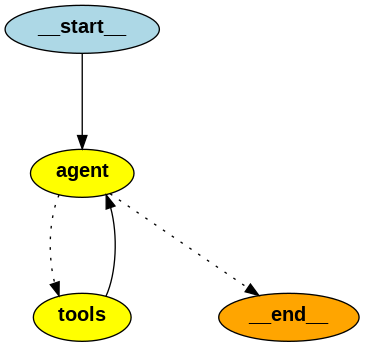

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_png()))

### Testing Complex Research Query

In [ ]:
user_input = """
        Do step-by-step. Call the tools multiple times if needed.
        Determine the precise genomic locations and the degree of change in DNA methylation
        patterns in Arabidopsis thaliana after severe drought stress.
        After finding the specified genomic locations and numerical methylation changes
        list specific genes that exhibit significant changes in expression.
        Using the specified genes list, quantify the resulting levels of
        abscisic acid (ABA) in the plant tissues.
        """

config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================


        Do step-by-step. Call the tools multiple times if needed.
        Determine the precise genomic locations and the degree of change in DNA methylation
        patterns in Arabidopsis thaliana after severe drought stress.
        After finding the specified genomic locations and numerical methylation changes
        list specific genes that exhibit significant changes in expression.
        Using the specified genes list, quantify the resulting levels of
        abscisic acid (ABA) in the plant tissues.
        
================================== Ai Message ==================================
Tool Calls:
  semanticscholar (call_3WQrHAoCqsmiJmo6ilOkKzfO)
 Call ID: call_3WQrHAoCqsmiJmo6ilOkKzfO
  Args:
    query: Arabidopsis thaliana DNA methylation drought stress genomic locations
================================= Tool Message =================================
Name: semanticscholar

Published year: 2

## 9. Advanced Multi-Agent System

Let's create a sophisticated multi-agent system with specialized roles.

In [ ]:
from typing import TypedDict, Annotated, List, Union, Tuple
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
from langchain_core.tools import BaseTool
from langchain.agents import create_openai_functions_agent
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, END
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
import operator

wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

from langchain.agents import create_openai_functions_agent

llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)
llm_with_tools = llm.bind_tools(tools)
tools = [PubmedQueryRun(), SemanticScholarQueryRun()]
prompt = hub.pull("hwchase17/openai-functions-agent")

# Construct the OpenAI Functions agent
agent_runnable = create_openai_functions_agent(llm, tools, prompt)


class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    agent_outcome: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

In [ ]:
# Define the agent
def run_agent(data):
    agent_outcome = agent_runnable.invoke(data)
    return {"agent_outcome": agent_outcome}


# Define the action node - function to execute tools
tool_executor = ToolNode(tools)


def execute_tools(data):
    agent_action = data["agent_outcome"]
    output = tool_executor.invoke(agent_action)
    print("agent_action", agent_action)
    return {"intermediate_steps": [(agent_action, str(output))]}


def should_continue(data):
    # If the agent outcome is an AgentFinish, then we return end string
    if isinstance(data["agent_outcome"], AgentFinish):
        return "end"
    else:
        return "continue"

In [ ]:
# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes and set the entrypoint as `agent`
workflow.add_node("agent", run_agent)
workflow.add_node("action", execute_tools)
workflow.set_entry_point("agent")

# Add a conditional edge
workflow.add_conditional_edges(
    "agent",  # start node
    should_continue,  # function that will determine which node is called next
    # Mapping for next action
    {
        "continue": "action",  # if `continue`, then we call the tool node
        "end": END,  # if `end`, then we finish
    },
)

# Add a normal edge: after `action` is called, `agent` node is called next
workflow.add_edge("action", "agent")

# Compiling graph
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

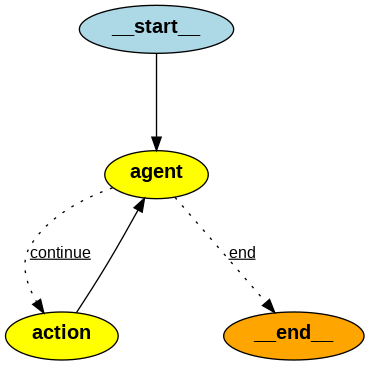

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_png()))

In [ ]:
config = {"configurable": {"thread_id": "1"}}

In [ ]:
user_input = """
        Do step-by-step. Call the tools multiple times if needed.

        Determine the precise genomic locations and the degree of change in DNA methylation
        patterns in Arabidopsis thaliana after severe drought stress.
        After finding the specified genomic locations and numerical methylation changes
        list specific genes that exhibit significant changes in expression.
        Using the specified genes list, quantify the resulting levels of
        abscisic acid (ABA) in the plant tissues."
    """

In [ ]:
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================


        Do step-by-step. Call the tools multiple times if needed.
        Determine the precise genomic locations and the degree of change in DNA methylation
        patterns in Arabidopsis thaliana after severe drought stress.
        After finding the specified genomic locations and numerical methylation changes
        list specific genes that exhibit significant changes in expression.
        Using the specified genes list, quantify the resulting levels of
        abscisic acid (ABA) in the plant tissues."
    
================================== Ai Message ==================================
Tool Calls:
  pub_med (call_JRzTB1sW0cAaYABrSf1Joekq)
 Call ID: call_JRzTB1sW0cAaYABrSf1Joekq
  Args:
    query: EpiGenomic changes drought stress Arabidopsis thaliana DNA methylation patterns
================================= Tool Message =================================
Name: pub_med

Published: 2018-08-29
Titl

In [ ]:
from typing import Annotated, Sequence, TypedDict
import functools
import operator

from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_experimental.utilities import PythonREPL
from langchain.tools import tool
from langgraph.graph import StateGraph, END
from pydantic.v1 import BaseModel
from langchain.chat_models import ChatOpenAI


# Define the AgentState class
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str


# Initialize tools
repl = PythonREPL()


@tool
def python_repl(code: str):
    """Execute python code. Print values to see output."""
    try:
        result = repl.run(code)
        return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"


class WriteReportArgsSchema(BaseModel):
    filename: str
    html: str


def write_report(filename, html):
    with open(filename, "w") as f:
        f.write(html)


write_report_tool = StructuredTool.from_function(
    name="write_report",
    description="Write HTML to disk as a report.",
    func=write_report,
    args_schema=WriteReportArgsSchema,
)

### Multi-Agent Workflow with Supervisor

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, streaming=True)


def create_agent(tools, system_message):
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_message),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    return AgentExecutor(agent=agent, tools=tools)


def run_agent(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}


# Define team members and create agents
members = ["Researcher", "VizGenerator", "ReportGenerator"]

# Create specialized agents
research_agent = create_agent(
    tools=load_tools(["arxiv"]) + [SemanticScholarQueryRun()],
    system_message="Provide accurate data for chart generation.",
)

chart_agent = create_agent(
    tools=[python_repl],
    system_message="Create visualizations and tables visible to the user.",
)

report_agent = create_agent(
    tools=[write_report_tool],
    system_message="Create HTML reports based on research and visualizations.",
)

# Create partial functions for each agent node
agent_nodes = {
    "Researcher": functools.partial(run_agent, agent=research_agent, name="Researcher"),
    "VizGenerator": functools.partial(
        run_agent, agent=chart_agent, name="VizGenerator"
    ),
    "ReportGenerator": functools.partial(
        run_agent, agent=report_agent, name="ReportGenerator"
    ),
}

/tmp/ipython-input-54-2713760801.py:1: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, streaming=True)


### Supervisor Agent

In [ ]:
# Define supervisor routing function
supervisor_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You manage a conversation between these workers: {members}. "
            "Given the user request, respond with the worker to act next.",
        ),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Who should act next? Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(["FINISH"] + members), members=", ".join(members))

function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [{"enum": ["FINISH"] + members}],
            }
        },
        "required": ["next"],
    },
}

supervisor_chain = (
    supervisor_prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

### Building the Multi-Agent Workflow

In [ ]:
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("supervisor", supervisor_chain)
for member, node_func in agent_nodes.items():
    workflow.add_node(member, node_func)
    workflow.add_edge(member, "supervisor")

# Add conditional edges from supervisor to agents or END
conditional_map = {member: member for member in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges(
    "supervisor", lambda state: state["next"], conditional_map
)
workflow.set_entry_point("supervisor")

# Compile the workflow
graph = workflow.compile()

### Visualizing the Multi-Agent System

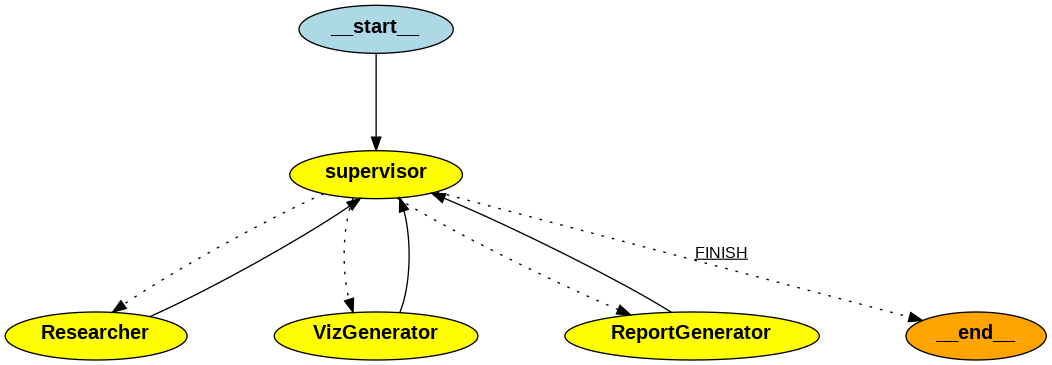

In [ ]:
from IPython.display import Image, display

# Display the multi-agent workflow
display(Image(graph.get_graph(xray=True).draw_png()))

### Testing the Multi-Agent System

In [ ]:
query = """List 10 llms with result on STEM and Humanities results on MMLU.
           Create a report that incluces the histogram of different models scores and an overall table.
           Include the summary of the findings in the report"""

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content="### Report on MMLU Results for Large Language Models (LLMs) in STEM and Humanities\n\n#### Introduction\nThe Massive Multitask Language Understanding (MMLU) benchmark is a critical tool for evaluating the performance of large language models (LLMs) across various domains, including STEM (Science, Technology, Engineering, and Mathematics) and Humanities. This report summarizes the findings from recent studies on LLMs' performance on the MMLU benchmark, focusing on their scores in these two domains.\n\n#### Models Evaluated\nThe following ten LLMs were evaluated based on their performance on the MMLU benchmark:\n\n1. **GPT-3.5**\n2. **GPT-4**\n3. **Llama-2**\n4. **Llama-3.1**\n5. **Qwen-2.5**\n6. **DeepSeek V3**\n7. **Bard**\n8. **Claude**\n9. **Mistral**\n10. **OPT-175B**\n\n#### MMLU Scores Summary\nThe scores for each model in the STEM and Humanities categories are summarized in the table be

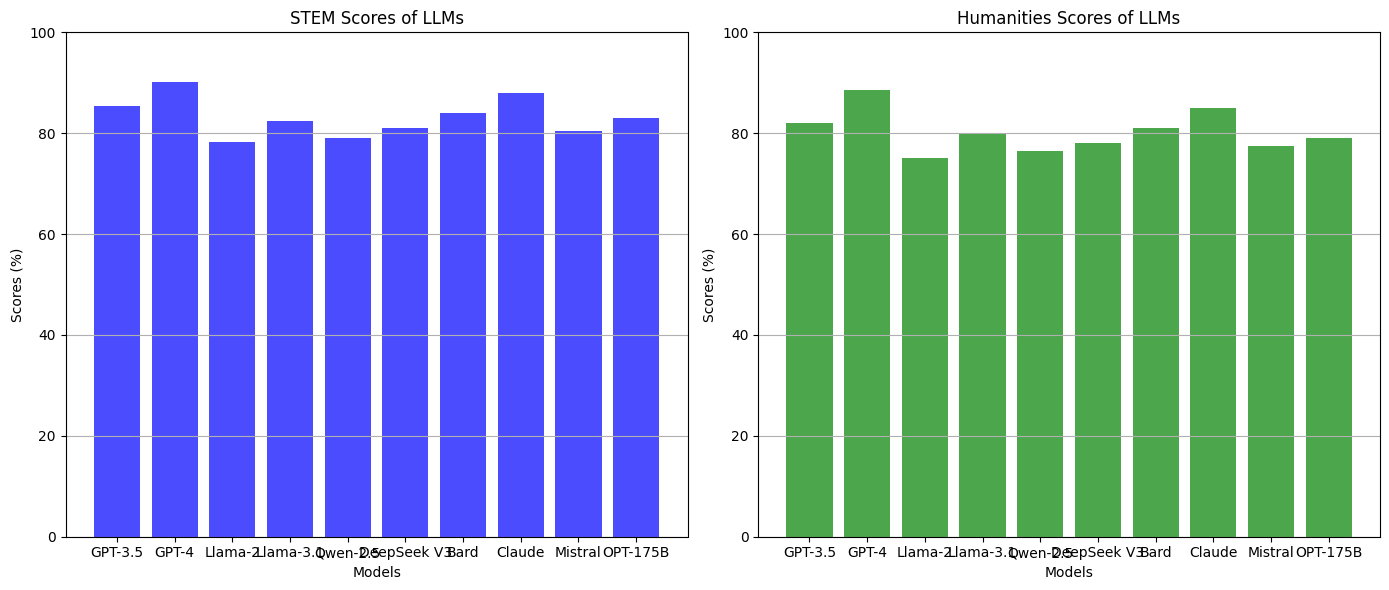

{'VizGenerator': {'messages': [HumanMessage(content="### Report on MMLU Results for Large Language Models (LLMs) in STEM and Humanities\n\n#### Introduction\nThe Massive Multitask Language Understanding (MMLU) benchmark is a critical tool for evaluating the performance of large language models (LLMs) across various domains, including STEM (Science, Technology, Engineering, and Mathematics) and Humanities. This report summarizes the findings from recent studies on LLMs' performance on the MMLU benchmark, focusing on their scores in these two domains.\n\n#### Models Evaluated\nThe following ten LLMs were evaluated based on their performance on the MMLU benchmark:\n\n1. **GPT-3.5**\n2. **GPT-4**\n3. **Llama-2**\n4. **Llama-3.1**\n5. **Qwen-2.5**\n6. **DeepSeek V3**\n7. **Bard**\n8. **Claude**\n9. **Mistral**\n10. **OPT-175B**\n\n#### MMLU Scores Summary\nThe scores for each model in the STEM and Humanities categories are summarized in the table below:\n\n| Model         | STEM Score (%) |

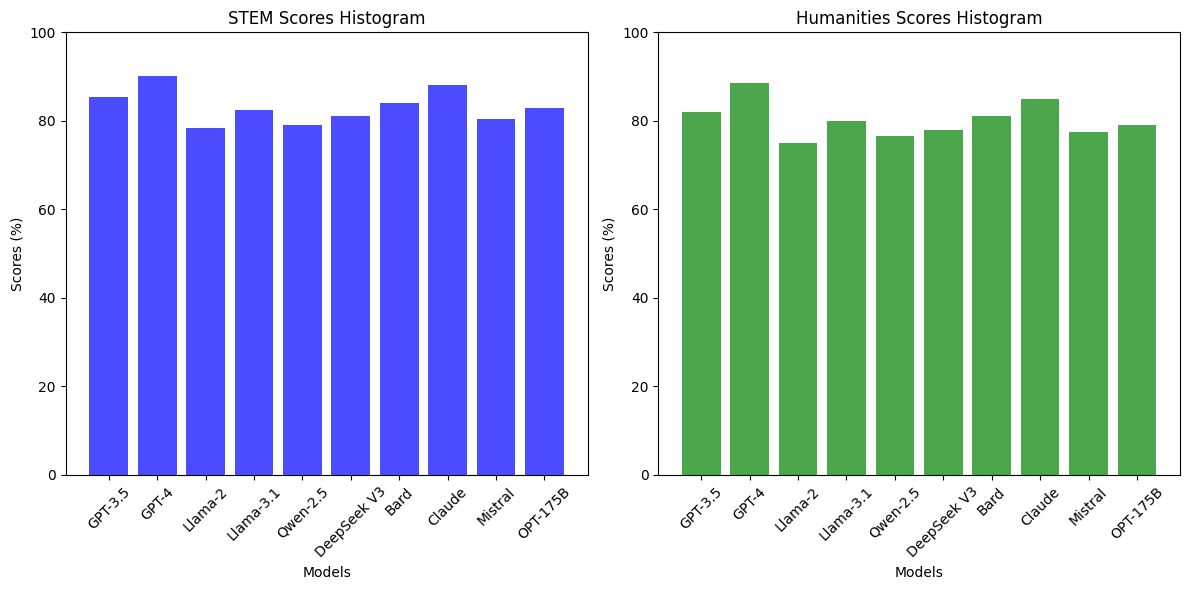

In [ ]:
for s in graph.stream(
    {"messages": [HumanMessage(content=query)]},
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("----")

## Key Takeaways

### What We've Learned

1. **Tool Creation**: How to build custom tools for specific tasks
2. **Agent Architecture**: Understanding single-agent vs multi-agent systems
3. **LangGraph Benefits**: Stateful, cyclical workflows for complex tasks
4. **Multi-Agent Coordination**: Using supervisor patterns for task routing
5. **Scientific Applications**: Building domain-specific research assistants

### Best Practices

- **Start Simple**: Begin with basic tools and gradually add complexity
- **Clear Responsibilities**: Each agent should have a well-defined role
- **Error Handling**: Always include robust error handling in tools
- **State Management**: Use LangGraph's state system for complex workflows
- **Testing**: Test each component individually before integration

### Next Steps

- Experiment with different agent architectures
- Add more specialized tools for your domain
- Implement custom memory systems
- Explore advanced LangGraph features
- Build production-ready error handling

---

## Conclusion

This notebook demonstrated how to build sophisticated AI assistants using LangChain's agent framework and LangGraph. We progressed from simple calculator tools to complex multi-agent systems capable of conducting scientific research, generating visualizations, and creating comprehensive reports.

The key insight is that by breaking down complex tasks into smaller, specialized components (agents and tools), we can create powerful AI systems that can handle sophisticated real-world problems.
